<a href="https://colab.research.google.com/github/Isabellitankian/FIAP-2022/blob/main/Tratamento_de_imagens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Checkpoint - Classificação de Imagens com CNNs**  ☁

**Isabellí Andrade** - RM: 96078 ⚛

**Caio Santos** - RM: 93250


Começar importando os cavaleiros do apocalipse: 🐴

In [ ]:
import matplotlib as plt
import pandas as pd
import numpy as np
import seaborn as sns 
import tensorflow as tf 
import keras 
from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from sklearn.metrics import confusion_matrix
from glob import glob
import random
from sklearn.model_selection import train_test_split

In [ ]:
!pip install kaggle

Importando os dados:

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Baixando o dataset:

In [ ]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

Crie uma pasta data e descompacte o dataset nela.

In [ ]:
!mkdir data
!unzip breast-histopathology-images.zip -d data 

## Preparando os dados para uso

Descubra os nomes das imagens da classe 0 (negativa, não câncer) e da classe 1 (positiva, câncer). 

In [ ]:
imagePatches = glob("/content/data/IDC_regular_ps50_idx5/**/*.png", recursive=True)

class0 = []
class1 = []

for filename in imagePatches:
  if filename.endswith("class0.png"):
    class0.append(filename)
  else:
    class1.append(filename)

Diminua o tamanho do dataset, pois não queremos demorar demais no treinamento.

In [ ]:
nClass0 = len(class0)
nClass1 = len(class1)

print(f"Existem {nClass0} exemplos negativos e {nClass1} exemplos positivos.")
print(f"Vamos usar apenas uma amostragem igualitária de cada classe!")
print(f"Então nosso dataset final deve ter {nClass1} exemplos de cada classe.")

sampled_class0 = random.sample(class0, nClass1)
sampled_class1 = random.sample(class1, nClass1)

#sampled_class0 = random.sample(class0, 10000)
#sampled_class1 = random.sample(class1, 10000)

print(f"Dataset final: ")
print(f"  - N classe negativa: {len(sampled_class0)}")
print(f"  - N classe positiva: {len(sampled_class1)}")

Existem 198738 exemplos negativos e 78786 exemplos positivos.
Vamos usar apenas uma amostragem igualitária de cada classe!
Então nosso dataset final deve ter 78786 exemplos de cada classe.
Dataset final: 
  - N classe negativa: 78786
  - N classe positiva: 78786


Cria um array de tuplas para cada classe, sendo que a tupla está no formato (imagem, label), sendo:

- imagem: a imagem no formato de matriz de pixels
- label: int indicando o label (0 ou 1)

In [ ]:
from matplotlib.image import imread
import cv2

def get_image_arrays(data, label):
  img_arrays = []
  for i in data:
    if i.endswith(".png"):
      img = cv2.imread(i, cv2.IMREAD_COLOR)
      img_sized = cv2.resize(img, (50, 50), interpolation=cv2.INTER_LINEAR)
      img_arrays.append([img_sized, label])
  return img_arrays 

class0_array = get_image_arrays(sampled_class0, 0)
class1_array = get_image_arrays(sampled_class1, 1)

Junte os dados numa coisa só, e misture, mesclando as imagens para trazer aleatoriedade na seleção. (Eu particulamente tenho medo disso, mas se você ta instruindo, eu confio) kkk 

In [ ]:
all_data = np.concatenate((class0_array, class1_array))
random.seed(42)
random.shuffle(all_data)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Separe os dados (pixels), dos labels (ints). Devemos terminar com 157572 imagens, escaladas em 50x50 pixels, sendo que cada imagem é expressa em 3 canais (RBG).

In [ ]:
X = []
y = []
for image, label in all_data:
  X.append(image)
  y.append(label)

X = np.array(X).reshape(-1, 50, 50, 3)
X.shape

(157572, 50, 50, 3)

Dividindo entre treino e teste: 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(118179, 50, 50, 3) (39393, 50, 50, 3) (118179, 2) (39393, 2)


Define a arquitetura da CNN -> camada de extração de features: 

Define a arquitetura da CNN -> camada de decisão (classificação):

In [ ]:
hand_model = Sequential()
hand_model.add( Rescaling(1./255, input_shape=(50, 50, 3)) )

hand_model.add( layers.Conv2D(16, kernel_size=10, activation="relu") )
hand_model.add( layers.MaxPooling2D(3) ) 

hand_model.add( layers.Conv2D(32, kernel_size=8, activation="relu") )
hand_model.add( layers.MaxPooling2D(2) ) 

hand_model.add( layers.Conv2D(32, kernel_size=2, activation="relu") )
hand_model.add( layers.MaxPooling2D(2) ) 
hand_model.add( layers.Flatten() )
hand_model.add( layers.Dense(50, activation="relu") )
hand_model.add( layers.Dense(20, activation="relu") )
hand_model.add( layers.Dense(2, activation="softmax") )

#Compila o modelo:

hand_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

#Define a estratégia de Early Stopping:

es = EarlyStopping(monitor="val_accuracy", 
                   patience=5,
                   mode="max",    #Se der erro comentar essa linha completa
                   restore_best_weights=True)

# Treinamento do modelo 
with tf.device("/device:GPU:0"):
  hand_model.fit(X_train, y_train,
                 epochs=50,
                 validation_split=0.2,
                 batch_size=32,
                 callbacks=[es])

Avaliação do modelo:

In [ ]:
loss, acc = hand_model.evaluate(X_train, y_train)

print(f"A loss do modelo é {loss:.2f} e a ACC é: {acc:.2f}")

3694/3694 [==============================] - 12s 3ms/step - loss: 0.2563 - accuracy: 0.8992
A loss do modelo é 0.26 e a ACC é: 0.90


Plotando uma matriz de confusão com o resultado:

In [ ]:
def plot_confusion_matrix(X_train, y_train):
  labels=list(map(np.argmax,y_train))
  labels_pred = list(map(np.argmax, y_train))

  cf_matrix = confusion_matrix(labels, labels_pred)
  sns.heatmap(cf_matrix, annot=True)

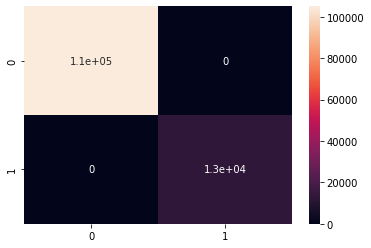

In [ ]:
predicoes = hand_model.predict(X_train)
plot_confusion_matrix(y_train, predicoes)

## Trabalhando com Transfer Learning do modelo VGG16

In [ ]:
# Imports
from tensorflow.keras.applications.vgg16 import VGG16 # Arquitetura padrão VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input # Função pra processar as imagens sobre a visão da arquitetura VGG16

# Preprocessa os dados de treinamento e teste
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

# Importa o modelo de base, que será a VGG16 ***sem*** a camada de decisão
base_model = VGG16(weights="imagenet", include_top=False, input_shape=X_train[0].shape)

# Usar os mesmos pesos da rede treinada (sem fine tunning)
base_model.trainable = False
#base_model.trainable = True

# Define as camadas treinaveis (com fine tunning)
#print("Número de camadas na base modelo: ", len(base_model.layers)) # Printa o número de camadas

#fine_tune_at = 100
#for layer in base_model.layers[:fine_tune_at]:
# layer.trainable = False # Até a camada 100, não é treinavel

In [ ]:
# Observa a estrutura do modelo importado
base_model.summary()

## Adicionar a camada de decisão (classificação)

In [ ]:
from tensorflow.keras import layers, models

# Define as camadas
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation="relu")
dense_layer_2 = layers.Dense(20, activation="relu")
prediction_layer = layers.Dense(2, activation="softmax")

# Estabelece o pipeline completo
model = models.Sequential([
    base_model,       # A base CNN da VGG16
    flatten_layer,    # Achata as features que saem da VGG16 (base_model) 
    dense_layer_1,    # Primeira camada oculta fully connected
    dense_layer_2,    # Segunda camada oculta fully connected
    prediction_layer  # Camada de saída, com 5 neurônios para classificação
])

In [ ]:
model.summary()

## Treinamento do modelo

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Compila o novo modelo
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Define a estratégia de Early Stopping
es = EarlyStopping(monitor="val_accuracy", mode="max", patience=5, restore_best_weights=True)

# Treina o modelo
model.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32, callbacks=[es])

In [ ]:
# Avaliação do modelo
loss, acc = model.evaluate(X_test, y_test)

print(f"A loss do modelo é {loss:.2f} e a ACC é: {acc:.2f}")

1232/1232 [==============================] - 13s 11ms/step - loss: 0.3271 - accuracy: 0.9026
A loss do modelo é 0.33 e a ACC é: 0.90


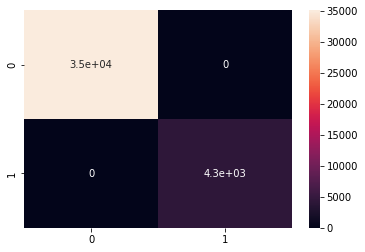

In [ ]:
preds = model.predict(X_test)
plot_confusion_matrix(y_test, preds)

## Considerações finais! ☝ Que rufem os tambores.... 🪗 (só encontrei o emoji da sanfona) kk



### A 1º proposta foi para criar uma rede convulacional do 0, que resultou em uma Acurácia de 0.90 e a Loss do modelo foi de 0.26. (UAU)

### E a 2º que foi utilizar a Transfer Learning do modelo VGG16, que resultou em uma Acurácia de 0.90 e a Loss do modelo foi de 0.33. (UAU again).

### Ou seja tanto a rede treinada do 0, quanto a transfer learning foram eficazes para a análise das imagens. ✨